# 机器学习回归模型预测黄金价格

## LinearRegression is a machine learning library for linear regression

In [1]:
from sklearn.linear_model import LinearRegression

## pandas and numpy are used for data manipulation 

In [2]:
import numpy as np
import pandas as pd

## matplotlib and seaborn are used for plotting graphs 

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn 
# fix_yahoo_finance is used to fetch data import fix_yahoo_finance as yf

## 引入 Markowitz 投资组合模型

In [ ]:
# import Markowitz as Mk

## Read data 

In [4]:
gold_df = pd.read_csv('data/LBMA-GOLD.csv')
bitcoin_df = pd.read_csv('data/BCHAIN-MKPRU.csv')

## Drop rows with missing values 

In [5]:
gold_df = gold_df.dropna()
bitcoin_df = bitcoin_df.dropna()

## Plot the price of Gold 

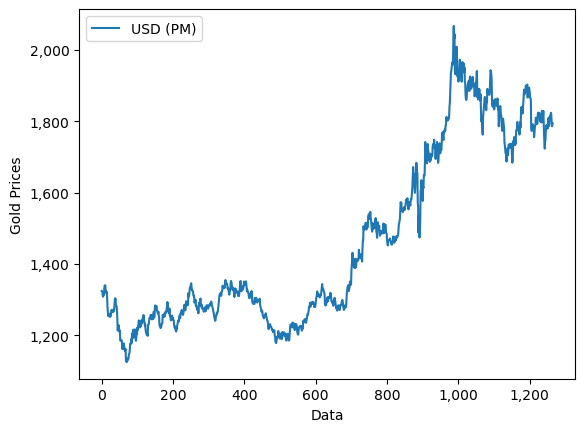

In [9]:
gold_df.plot()
plt.gca().xaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.gca().yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel("Data")
plt.ylabel("Gold Prices")

plt.savefig('Gold.svg', dpi=600, format='svg')

## Plot the price of bitcoin

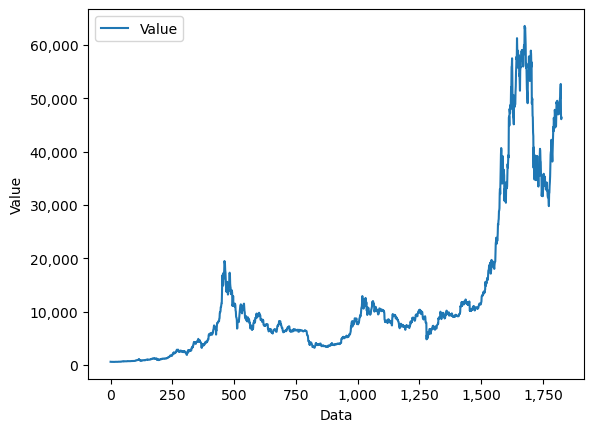

In [10]:
bitcoin_df.plot()
plt.gca().xaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.gca().yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel("Data")
plt.ylabel("Value")
plt.savefig("bitcon.svg", dpi=600, format="svg")

## 交易者在第i天到来

### 合并Dataframe

In [11]:
combination_df = pd.merge(bitcoin_df, gold_df, on=['Date'], how='outer')
combination_df.head()

,Date,Value,USD (PM)
0,9/11/16,621.65,NaN
1,9/12/16,609.67,1324.60
2,9/13/16,610.92,1323.65
3,9/14/16,608.82,1321.75
4,9/15/16,610.38,1310.80


## 设置影响因子

### Gold

In [12]:
# 过去2天价格波动平均值
gold_df['S_2'] = gold_df['USD (PM)'].shift(1).rolling(window=2).mean() 

# 过去4天价格波动平均值
gold_df['S_4'] = gold_df['USD (PM)'].shift(1).rolling(window=4).mean()

gold_df = gold_df.dropna()

X_gold = gold_df[['S_2','S_4']]

X_gold.head()

,S_2,S_4
4,1316.275,1320.2000
5,1309.575,1316.1375
6,1311.600,1313.9375
7,1314.325,1311.9500
8,1319.950,1315.7750


### Bitcoin

In [13]:
# 过去3天的价格波动平均值
bitcoin_df['S_3'] = bitcoin_df['Value'].shift(1).rolling(window=3).mean()

# 过去9天价格波动平均值
bitcoin_df['S_9'] = bitcoin_df['Value'].shift(1).rolling(window=9).mean()

bitcoin_df = bitcoin_df.dropna()

X_bit = bitcoin_df[['S_3','S_9']]

X_bit.head()

,S_3,S_9
9,609.603333,611.040000
10,610.143333,609.596667
11,605.910000,608.397778
12,601.653333,606.897778
13,596.793333,605.260000


## 每15天进行一次交易

### 设置初始状态

In [14]:
crash = 1000
gold = 0
bitcoin = 0
holdings = [crash, gold, bitcoin]
# gold_df = pd.concat([pd.DataFrame(combination_df['Date']), pd.DataFrame(combination_df['USD (PM)'])], axis = 1, join = 'outer')
gold_df.head()

,Date,USD (PM),S_2,S_4
4,9/16/16,1308.35,1316.275,1320.2000
5,9/19/16,1314.85,1309.575,1316.1375
6,9/20/16,1313.80,1311.600,1313.9375
7,9/21/16,1326.10,1314.325,1311.9500
8,9/22/16,1339.10,1319.950,1315.7750


### 假设每周期的交易时间黄金开市

## 设置预测值

### Gold

In [16]:
y_gold = gold_df['USD (PM)']

y_gold.head()

4    1308.35
5    1314.85
6    1313.80
7    1326.10
8    1339.10
Name: USD (PM), dtype: float64

### bitcoin

In [17]:
y_bit = bitcoin_df['Value']

y_bit.head()

9     608.66
10    598.88
11    597.42
12    594.08
13    603.88
Name: Value, dtype: float64

In [18]:
t = .8

t_gold = int(t*len(gold_df))
t_bit = int(t*len(bitcoin_df))

## Train dataset 

In [19]:
X_gold_train = X_gold[:t_gold]
X_bit_train = X_bit[:t_bit]

y_gold_train = y_gold[:t_gold]
y_bit_train = y_bit[:t_bit]

## Test dataset 

In [21]:
X_gold_test = X_gold[t_gold:]
X_bit_test = X_bit[t_bit:]

y_gold_test = y_gold[t_gold:]
y_bit_test = y_bit[t_bit:]


### Y = m1 * X1 + m2 * X2 + CGold ETF price = m1 * 3 days moving average + m2 * 15 days moving average + c

In [22]:
linear_gold = LinearRegression().fit(X_gold_train,y_gold_train)
linear_bit = LinearRegression().fit(X_bit_train,y_bit_train)

print("Gold Price =", round(linear_gold.coef_[0],2), "* 2 Days Moving Average", round(linear_gold.coef_[1],2), "* 4 Days Moving Average +", round(linear_gold.intercept_,2))
print("Bitcoin Value =", round(linear_bit.coef_[0],2), "* 3 Days Moving Average", round(linear_bit.coef_[1],2), "* 9 Days Moving Average +", round(linear_bit.intercept_,2))

Gold Price = 1.45 * 2 Days Moving Average -0.45 * 4 Days Moving Average + -2.27
Bitcoin Value = 1.22 * 3 Days Moving Average -0.23 * 9 Days Moving Average + 61.36


In [23]:
predicted_price_gold = linear_gold.predict(X_gold_test)  
predicted_price_gold = pd.DataFrame(predicted_price_gold,index=y_gold_test.index,columns = ['price'])

predicted_price_bit = linear_bit.predict(X_bit_test)  
predicted_price_bit = pd.DataFrame(predicted_price_bit,index=y_bit_test.index,columns = ['value'])

### Plot Gold

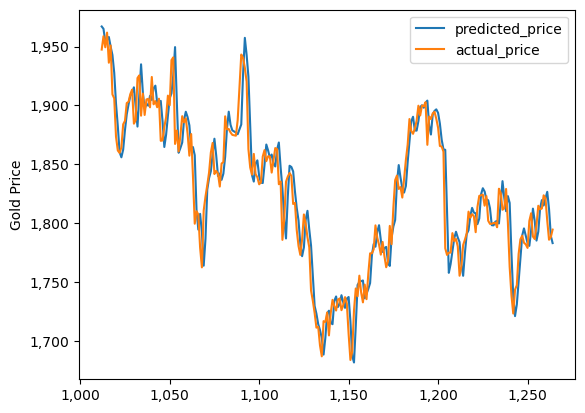

In [24]:
predicted_price_gold.plot()  

y_gold_test.plot() 

plt.gca().xaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.gca().yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.legend(['predicted_price','actual_price'])  

plt.ylabel("Gold Price")  

plt.savefig("Gold_pre.svg", dpi=600, format="svg")

### Plot Bitcoin

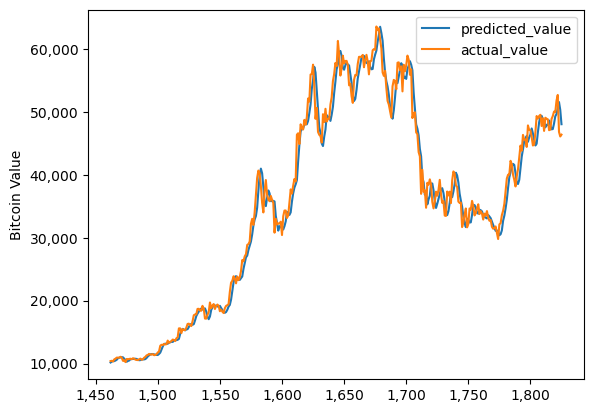

In [25]:
predicted_price_bit.plot()  

y_bit_test.plot() 

plt.gca().xaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.gca().yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.legend(['predicted_value','actual_value'])  

plt.ylabel("Bitcoin Value")  

plt.savefig("bitcon_pre.svg", dpi=600, format="svg")

# 计算拟合优度

### Gold

In [26]:
r2_score = linear_gold.score(X_gold[t_gold:],y_gold[t_gold:])*100  

float("{0:.2f}".format(r2_score))

89.44

### Bitcoin

In [27]:
r2_score = linear_bit.score(X_bit[t_bit:],y_bit[t_bit:])*100  

float("{0:.2f}".format(r2_score))

98.43